In [1]:
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
#import datashader as ds
import matplotlib.pyplot as plt
import seaborn as sns
#from scipy.stats.stats import pearsonr
#from sklearn.model_selection import train_test_split
#from sklearn.ensemble import RandomForestClassifier
#from sklearn import metrics
#from sklearn.metrics import mean_squared_log_error

%matplotlib inline
#sns.set_style('whitegrid')

In [2]:
# #API REQUEST
# #!/usr/bin/env python

# # make sure to install these packages before running:
# # pip install pandas
# # pip install sodapy

# import pandas as pd
# from sodapy import Socrata

# # Unauthenticated client only works with public data sets. Note 'None'
# # in place of application token, and no username or password:
# client = Socrata("data.austintexas.gov", 'O83OVoUZsV65dOxldd2Hw0SK6')

# # Example authenticated client (needed for non-public datasets):
# # client = Socrata(data.austintexas.gov,
# #                  MyAppToken,
# #                  userame="user@example.com",
# #                  password="AFakePassword")

# # First 2000 results, returned as JSON from API / converted to Python list of
# # dictionaries by sodapy.

# dataset_id = "7d8e-dm7r"
# query = "select device_id, modified_date, vehicle_type, trip_duration, trip_distance, start_time,\
#          end_time, census_geoid_start, census_geoid_end where month = 1 limit 1000"

# query2 = "select count(*) group by month where"
# results = client.get(dataset_id, query=query2)

# # Convert to pandas DataFrame
# results_df = pd.DataFrame.from_records(results)


In [3]:
#Set variable types to make reading the file faster
#Trip Duration is in seconds and Trip Distance is in meters
#Most companies charge based on time
dtype_dict = {'ID' : 'str',
              'Device ID': 'str',
              'Vehicle Type': 'str',
              'Trip Duration': 'float',
              'Trip Distance': 'float',
              'Start Time': 'str',
              'End Time': 'str',
              'Modified Date': 'str',
              'Month': 'str',
              'Hour': 'str',
              'Day of Week': 'str',
              'Council District (Start)': 'str',
              'Council District (End)': 'str',
              'Year': 'str',
              'Census Tract Start': 'str',
              'Census Tract End': 'str'
             }
print(dtype_dict)

{'ID': 'str', 'Device ID': 'str', 'Vehicle Type': 'str', 'Trip Duration': 'float', 'Trip Distance': 'float', 'Start Time': 'str', 'End Time': 'str', 'Modified Date': 'str', 'Month': 'str', 'Hour': 'str', 'Day of Week': 'str', 'Council District (Start)': 'str', 'Council District (End)': 'str', 'Year': 'str', 'Census Tract Start': 'str', 'Census Tract End': 'str'}


In [4]:
#load data and set index
df = pd.read_csv('Shared_Micromobility_Vehicle_Trips.csv', index_col = 'ID', dtype = dtype_dict)
df_backup = df


In [5]:
#Change datatypes to make operations faster
#df[['Trip Duration', 'Trip Distance', 'Month', 'Hour', 'Day of Week', 'Council District (Start)', 'Council District (End)', 'Year']] =df[['Trip Duration', 'Trip Distance', 'Month', 'Hour', 'Day of Week', 'Council District (Start)', 'Council District (End)', 'Year']].astype('float32')
df[['Trip Duration', 'Trip Distance', 'Hour', 'Month', 'Year']] =df[['Trip Duration', 'Trip Distance', 'Hour', 'Month', 'Year']].astype('float32')


In [6]:
#Getting rid of some nulls and zero
df_notnull = df[df['Trip Duration'].notna()]
df = df_notnull
#only got rid of one

# There are durations and distances with negative times. They have positive distances and times respectfully
# so let's flip the signs
# df_neg = df[df['Trip Duration'] < 0]
# df_neg.head(50)
def flipsign(x):
    if x>0:
        return x
    else:
        return x*-1

df['Trip Duration'] = df['Trip Duration'].apply(lambda x: flipsign(x))
df['Trip Distance'] = df['Trip Distance'].apply(lambda x: flipsign(x))

# Cleaning outliers
# Trips over 6 hours (average charge length) will be removed --  21600s
# The max speed is 15 mph, so no trips longer than (15mph * 6hours) * 1609m/mile = 144810m
df_duration_free = (df[df['Trip Duration'] < 21600])
df = (df_duration_free[df_duration_free['Trip Distance'] < 144810])

<ipython-input-6-a91e99c2a468>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Trip Duration'] = df['Trip Duration'].apply(lambda x: flipsign(x))
<ipython-input-6-a91e99c2a468>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Trip Distance'] = df['Trip Distance'].apply(lambda x: flipsign(x))


In [7]:
#Let's add a revenue column based on pricing
# Scooter Payments
#https://smarttripsaustin.org/shared-active-transportation/
#Bird - 4,500 scooters (see map for Bird's areas of operation) 1 to start and .25 for every minute
#JUMP - 2,500 scooters, 2,000 e-bikes (see map for Jump's areas of operation) 1 to start and .15 for every minute
#Lime - 5,000 scooters (see map for Lime's areas of operation) 1 to start and .15 for every minute
#Lyft - 2,000 scooters (see map for Lyft's areas of operation) 1 to start and .15 for every minute
#OjO - 1,000 scooters
#Spin - 750 scooters
#VeoRide - 300 scooters and 50 bicycles

#Bikes and scooter prices for JUMP is the same so we'll assume same for all:
# $1 to start plus $0.15 per minute-- based on a ride I took prices do not seem to be rounded

def ridePrice(time):
    cost = 1 + (.15/60) * time
    return(round(cost,2))

df['Cost'] = df['Trip Duration'].apply(lambda x: ridePrice(x))

<ipython-input-7-4c27ca447166>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cost'] = df['Trip Duration'].apply(lambda x: ridePrice(x))


In [8]:
#Let's look into individual vehicle performance by making a separate dataframe
df_agg_vehicle = df.groupby('Device ID').agg(
                                        Vehicle = ('Vehicle Type', lambda x: x.value_counts().index[0]),
                                        Total_Rides = ('Cost', 'count'),
                                        Money_Earned = ('Cost', sum),
                                        Total_Meters = ('Trip Distance', sum)
                                        
)


In [9]:
df_agg_vehicle.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70383 entries, 0001b2e9-a307-4cce-9d8e-4d348b89aae2 to fffd525f-0099-4047-88f2-76b527bd4f1f
Data columns (total 4 columns):
Vehicle         70383 non-null object
Total_Rides     70383 non-null int64
Money_Earned    70383 non-null float64
Total_Meters    70383 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.7+ MB


In [10]:
df_agg_vehicle[df_agg_vehicle['Vehicle'] == 'scooter']

,Vehicle,Total_Rides,Money_Earned,Total_Meters
Device ID,,,,
0001b2e9-a307-4cce-9d8e-4d348b89aae2,scooter,34,100.93,40922.0
0003f834-60c7-434b-82b1-b75d64278e52,scooter,14,43.70,14296.0
00066528-4d85-4cc8-bacf-a904f3ec96d8,scooter,457,1135.13,574661.0
0008292e-2ae0-426f-81bc-6dd116ea160f,scooter,80,208.65,66578.0
00098c81-19fc-4bc5-9162-4fbf2c3a4e34,scooter,86,206.67,116585.0
...,...,...,...,...
fff88552-9d94-4953-b49a-894929eec3ed,scooter,52,113.51,55695.0
fff9898c-2450-49c6-b926-5b9cd152aafe,scooter,175,468.47,190809.0
fffa29f1-e1df-43e0-8141-477a024167b0,scooter,48,93.64,40769.0


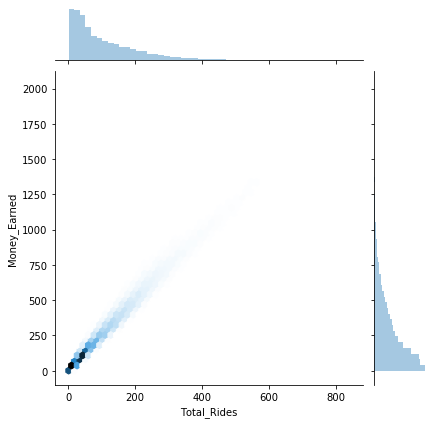

In [11]:
#f, ax = plt.subplots(1, 2, figsize=(7, 7), sharex=True)
sns.jointplot(x='Total_Rides', 
              y= 'Money_Earned', 
              data = df_agg_vehicle[df_agg_vehicle['Vehicle'] == 'scooter'],
              kind = 'hex'
              #ax=ax[1,1]
             )
#sns.jointplot(x='Total_Rides', y= 'Money_Earned', data = df_agg_vehicle, ax=ax[0,1])

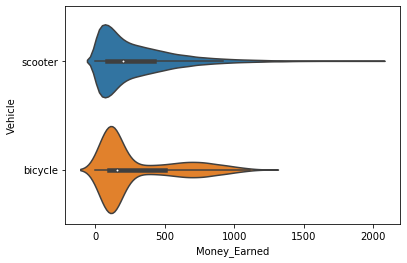

In [12]:
sns.violinplot(x='Money_Earned', data = df_agg_vehicle, y='Vehicle')

In [13]:
df_agg_small = df_agg_vehicle[df_agg_vehicle['Money_Earned']<100]
df_agg_small.info()
#df_agg_small[df_agg_small['Vehicle']=='bicycle']

<class 'pandas.core.frame.DataFrame'>
Index: 19861 entries, 0003f834-60c7-434b-82b1-b75d64278e52 to fffa29f1-e1df-43e0-8141-477a024167b0
Data columns (total 4 columns):
Vehicle         19861 non-null object
Total_Rides     19861 non-null int64
Money_Earned    19861 non-null float64
Total_Meters    19861 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 775.8+ KB


Devices Notes:
There are lots of devices that earn under $10. I assume this is because they get damaged or their Device ID changes after a repair. The average BIRD scooter costs $1300 (https://techcrunch.com/2019/05/08/bird-is-now-selling-its-electric-scooters-directly-to-consumers/) and the bicycles are more expensive.
Few of the vehicles recoup their initial costs and that’s not including the charging costs either.


In [14]:
#Create aggregated table by hour of day
df_agg_time = df.groupby(['Hour','Vehicle Type']).agg(
                                        Total_Rides = ('Cost', 'count'),
                                        Money_Earned = ('Cost', sum),
                                        Total_Meters = ('Trip Distance', sum)                   
)
df_agg_time= df_agg_time.reset_index()

In [15]:
df_agg_time= df_agg_time.reset_index()
df_agg_time.head()

,index,Hour,Vehicle Type,Total_Rides,Money_Earned,Total_Meters
0,0,0.0,bicycle,8957,29405.81,20670731.0
1,1,0.0,scooter,148065,375779.58,192493645.0
2,2,1.0,bicycle,6636,22831.75,15833992.0
3,3,1.0,scooter,102477,264625.70,137644613.0
4,4,2.0,bicycle,6334,23954.44,16378736.0


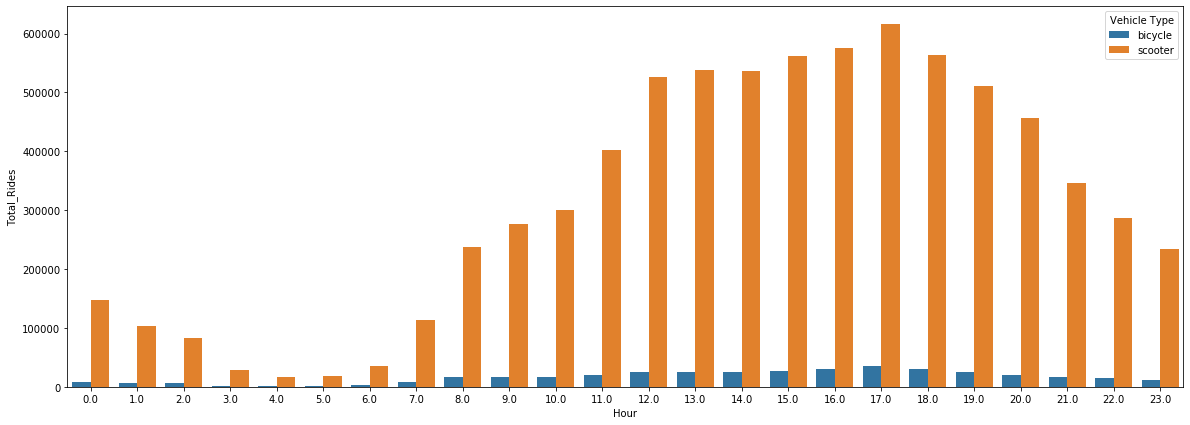

In [16]:
#Times are represened by 24 hour clock
plt.figure(figsize=(20,7))
sns.barplot(data=df_agg_time, x='Hour', y='Total_Rides', hue= 'Vehicle Type')

Hour of Day:
Most rides occur in the evening and coincide with rush hour.

In [17]:
#Aggregated table by Day of Week
df_agg_dow = df.groupby(['Day of Week','Vehicle Type']).agg(
                                        Total_Rides = ('Cost', 'count'),
                                        Money_Earned = ('Cost', sum),
                                        Total_Meters = ('Trip Distance', sum)                   
)
df_agg_dow = df_agg_dow.reset_index()
DOW_dict= {'0': 'Sunday',
           '1': 'Monday',
           '2': 'Tuesday',
           '3': 'Wednesday',
           '4': 'Thursday',
           '5': 'Friday',
           '6': 'Saturday',
          }
df_agg_dow['Day of Week'] = df_agg_dow['Day of Week'].replace(DOW_dict)
df_agg_dow.head(15)


,Day of Week,Vehicle Type,Total_Rides,Money_Earned,Total_Meters
0,Sunday,bicycle,59530,2.300640e+05,1.707048e+08
1,Sunday,scooter,1098401,3.142094e+06,1.760152e+09
2,Monday,bicycle,50716,1.671055e+05,1.314990e+08
3,Monday,scooter,884743,2.167243e+06,1.225862e+09
4,Tuesday,bicycle,49287,1.539203e+05,1.224513e+08
5,Tuesday,scooter,891963,2.076739e+06,1.157932e+09
6,Wednesday,bicycle,49245,1.556100e+05,1.223516e+08
7,Wednesday,scooter,901191,2.090484e+06,1.173292e+09
8,Thursday,bicycle,53939,1.748984e+05,1.361690e+08
9,Thursday,scooter,1025881,2.460347e+06,1.375806e+09


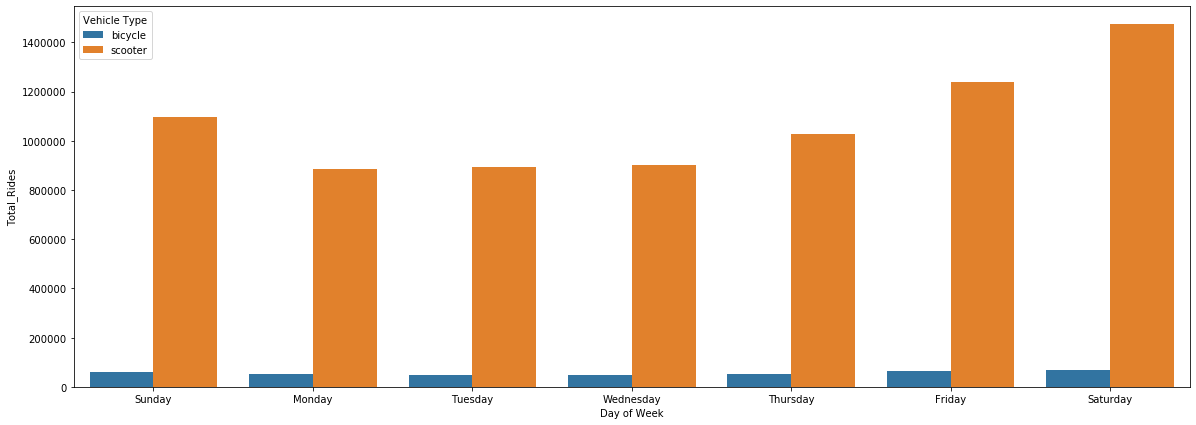

In [18]:
#Times are represened by 24 hour clock
plt.figure(figsize=(20,7))
sns.barplot(data=df_agg_dow, x='Day of Week', y='Total_Rides', hue= 'Vehicle Type')

Day of Week:
I thought that the vehicles would be used more on the weekdays for commutes to work but it seems there are more rentals on the weekends. This is probably because they are still viewed as a fun, cruising vehicle rather than mode of transport to and from work.


In [19]:
df_agg_month = df.groupby(['Month','Year','Vehicle Type']).agg(
                                        Total_Vehicles = ('Device ID', 'nunique'),
                                        Total_Rides = ('Cost', 'count'),
                                        Money_Earned = ('Cost', sum),
                                        Total_Meters = ('Trip Distance', sum)                   
)

df_agg_month= df_agg_month.reset_index()
df_agg_month = df_agg_month.sort_values(by=['Year', 'Month', 'Vehicle Type'])


df_agg_month['Date'] = df_agg_month['Month'].map(str)+ '-' +df_agg_month['Year'].map(str)
df_agg_month['Date'] = pd.to_datetime(df_agg_month['Date'], format='%m.0-%Y.0').dt.strftime('%m-%Y')


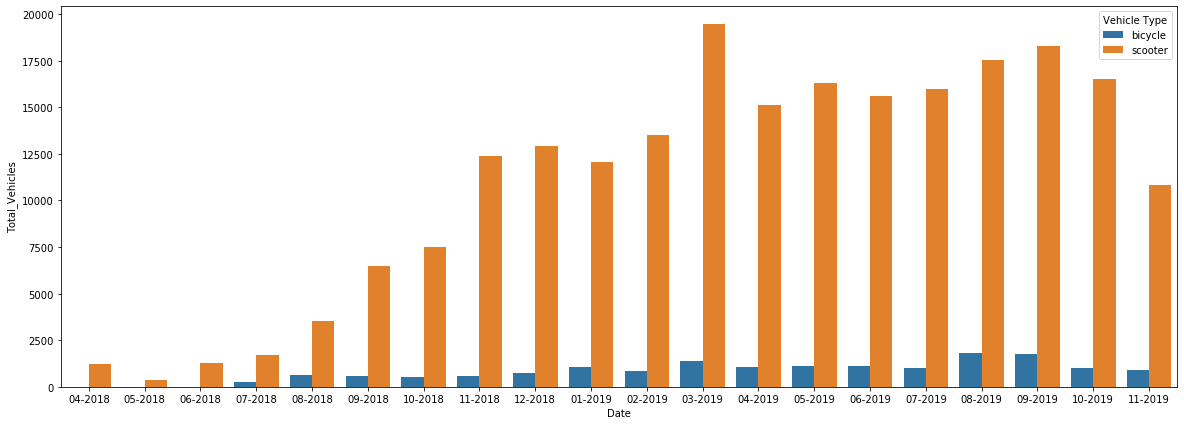

In [21]:
# Monthly plots: Note as time goes on more vehicles were added and 11-2019 is unfinished
plt.figure(figsize=(20,7))
sns.barplot(data=df_agg_month, x='Date', y='Total_Vehicles', hue = 'Vehicle Type')

Month:
I would think that there would be less rentals in the winters but Austin is pretty warm year round so there seems to be not much of a change month to month. I would like to see how the frequency of use changes in a city like New York month to month.

 

In [25]:
#https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2010&layergroup=Census+Tracts
fp = '/Users/arangwala/Documents/Scooter_Data/tl_2010_48_tract10/tl_2010_48_tract10.shp'
blocks = gpd.read_file(fp)

In [26]:
blocks_tx = blocks
blocks_453 = blocks[blocks['COUNTYFP10']=='453']

In [27]:
#Aggregate durations in a new table
df['Census Tract Start'].nunique()
df_census_start = df.groupby('Census Tract Start')['Cost'].agg(['sum', 'count'])

In [ ]:
df_census_start[df_census_start['count']>500000]

In [28]:
#Combine tables
#Reset index so you can name the column that matches the geo table
df_census_start.reset_index(inplace=True)
df_census_start['GEOID10'] = df_census_start['Census Tract Start']

merged_df = blocks_453.merge(df_census_start, on='GEOID10')

In [29]:
merged_df.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 212 entries, 0 to 211
Data columns (total 16 columns):
STATEFP10             212 non-null object
COUNTYFP10            212 non-null object
TRACTCE10             212 non-null object
GEOID10               212 non-null object
NAME10                212 non-null object
NAMELSAD10            212 non-null object
MTFCC10               212 non-null object
FUNCSTAT10            212 non-null object
ALAND10               212 non-null int64
AWATER10              212 non-null int64
INTPTLAT10            212 non-null object
INTPTLON10            212 non-null object
geometry              212 non-null geometry
Census Tract Start    212 non-null object
sum                   212 non-null float64
count                 212 non-null int64
dtypes: float64(1), geometry(1), int64(3), object(11)
memory usage: 28.2+ KB


In [30]:
merged_df = merged_df.rename(columns= {'sum': 'Sum', 'count': 'Count'})
merged_df.head(200)

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,Census Tract Start,Sum,Count
0,48,453,001857,48453001857,18.57,Census Tract 18.57,G5020,S,7103720,12579,+30.4619546,-097.6542643,"POLYGON ((-97.65150 30.45602, -97.65155 30.455...",48453001857,109.31,22
1,48,453,001862,48453001862,18.62,Census Tract 18.62,G5020,S,4098223,0,+30.4530833,-097.6266893,"POLYGON ((-97.62948 30.44392, -97.62968 30.444...",48453001862,62.33,14
2,48,453,001855,48453001855,18.55,Census Tract 18.55,G5020,S,18878076,5095,+30.4750263,-097.6114913,"POLYGON ((-97.61030 30.49018, -97.61008 30.490...",48453001855,174.71,22
3,48,453,001858,48453001858,18.58,Census Tract 18.58,G5020,S,30633941,8413,+30.4594972,-097.5774418,"POLYGON ((-97.61391 30.43659, -97.61357 30.437...",48453001858,60.91,11
4,48,453,001779,48453001779,17.79,Census Tract 17.79,G5020,S,20110903,2864614,+30.4407103,-098.0003743,"POLYGON ((-97.98621 30.47687, -97.98632 30.476...",48453001779,3.53,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,48,453,001714,48453001714,17.14,Census Tract 17.14,G5020,S,17611666,0,+30.4243035,-097.8278626,"POLYGON ((-97.83624 30.43961, -97.83597 30.439...",48453001714,161.19,69
196,48,453,001403,48453001403,14.03,Census Tract 14.03,G5020,S,800634,0,+30.2399174,-097.7350703,"POLYGON ((-97.74023 30.23555, -97.73865 30.238...",48453001403,18577.65,6354
197,48,453,001733,48453001733,17.33,Census Tract 17.33,G5020,S,22580505,4561,+30.2148733,-097.9171838,"POLYGON ((-97.92696 30.18995, -97.92790 30.188...",48453001733,10.19,1
198,48,453,001769,48453001769,17.69,Census Tract 17.69,G5020,S,8990867,0,+30.2426630,-097.9012650,"POLYGON ((-97.92342 30.24331, -97.92370 30.243...",48453001769,61.93,25


In [34]:
merged_df_nooutlie = merged_df[merged_df['GEOID10'] != '48453001100']

In [ ]:
merged_df_nooutlie.info()
merged_df.info()

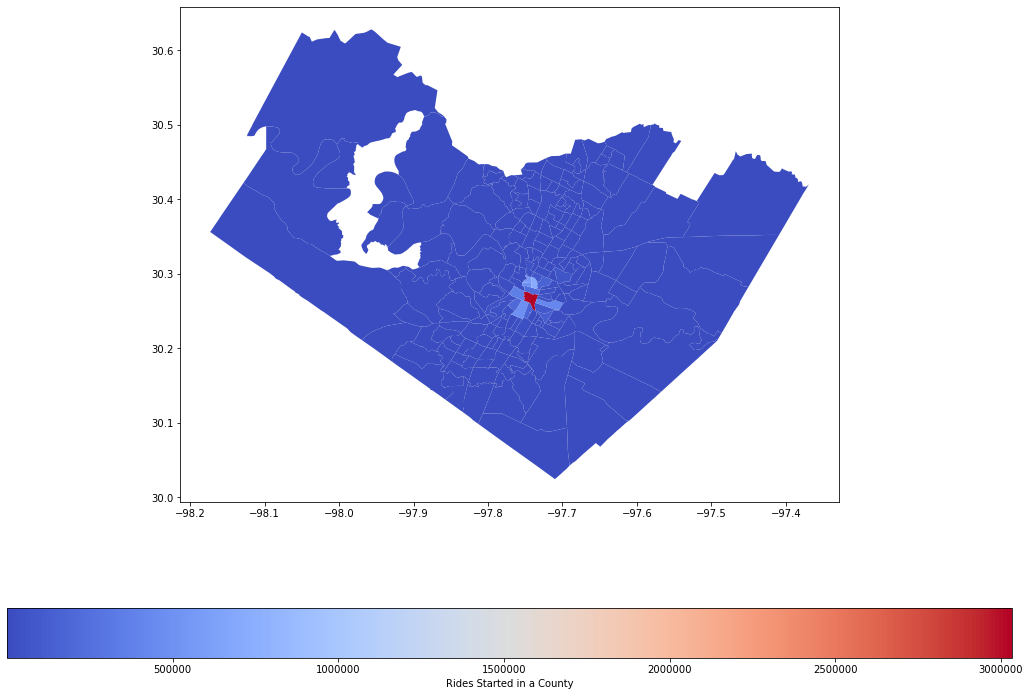

In [32]:

fig, ax = plt.subplots(figsize = (18,13))
#ax.set_xlim(-97.79, -97.675)
#ax.set_ylim(30.22, 30.31)
merged_df.plot(column = 'Count', 
                         ax=ax, 
                         legend=True,
                         cmap='coolwarm',
                         legend_kwds={'label': "Rides Started in a County",
                        'orientation': "horizontal"}
                        )

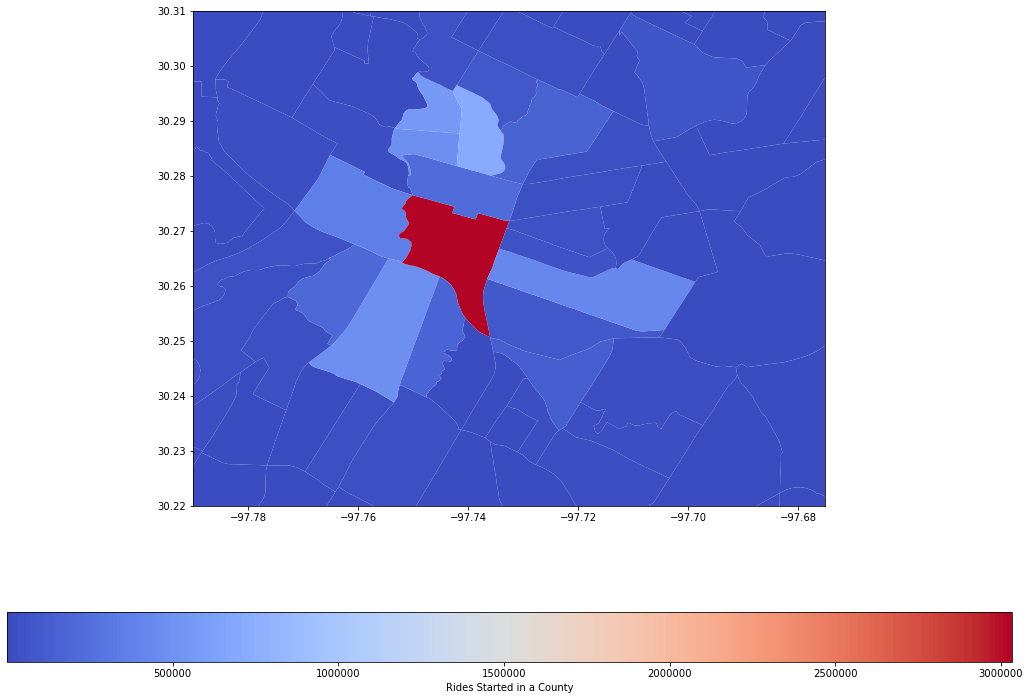

In [33]:

fig, ax = plt.subplots(figsize = (18,13))
ax.set_xlim(-97.79, -97.675)
ax.set_ylim(30.22, 30.31)
merged_df.plot(column = 'Count', 
                         ax=ax, 
                         legend=True,
                         cmap='coolwarm',
                         legend_kwds={'label': "Rides Started in a County",
                        'orientation': "horizontal"}
                        )

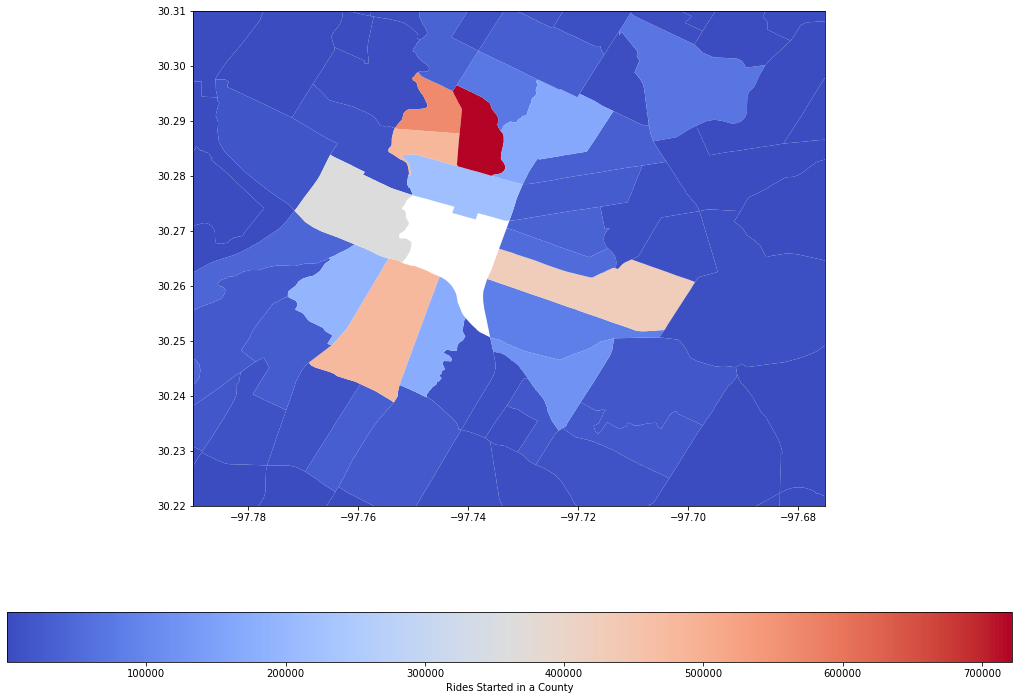

In [35]:
fig, ax = plt.subplots(figsize = (18,13))
ax.set_xlim(-97.79, -97.675)
ax.set_ylim(30.22, 30.31)
merged_df_nooutlie.plot(column = 'Count', 
                         ax=ax, 
                         legend=True,
                         cmap='coolwarm',
                         legend_kwds={'label': "Rides Started in a County",
                        'orientation': "horizontal"}
                        )

In [ ]:
test.head()

In [ ]:
test[test['STATEFP10']>100]